### Imports

In [1]:
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.layers import Lambda, MaxPool2D, AvgPool2D, Layer, Input, Subtract, Multiply, Add
from tensorflow.keras.models import Model

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('../utilities')
from utilities import (
    load_image,
    show_image,
    vgg19_process_image,
    vgg19_deprocess_image,
    precomputed_loss,
    get_image_from_model
)

### Custom Layers
- Gram Matrix: Used for style extraction. See the original paper [A Neural Algorithm of Artistic Style (Gatys et al.)](https://arxiv.org/abs/1508.06576)
- Source: an inputless layer that only outputs weights (i.e. is a source in the directed graph). These weights will serve as the image in the transfer model

In [4]:
from utilities import gram_matrix, Source

### Model Setup
We need two models.
- Extract: extract the style and content from the style and content images respectively
- Transfer: given the desired activations, compute the combined image

We also have a utility function to extract the image from the transfer model (the image is not produced as an output)

In [6]:
def get_style_transfer_models(base_model, style_layers, content_layers, width, height, style_content_weighting):
    
    # Build the extractive model
    base_model.trainable   = False
    num_style_outputs      = len(style_layers)

    style_outputs   = []
    content_outputs = []

    for i, layer in enumerate(base_model.layers):
        if i == 0:
            # Custom input size
            input_      = tf.keras.layers.Input(shape = (width, height, 3))
            current     = input_
        elif isinstance(layer, MaxPool2D):
            # Replace max pooling with average pooling
            pool_config = layer.get_config()
            avg_pool    = AvgPool2D().from_config(pool_config)
            current     = avg_pool(current)
        else:
            current = layer(current)

        if layer.name in style_layers:
            # Compute gram matrix as a style output
            style_outputs.append(Lambda(gram_matrix, name = f'gram_{layer.name}')(current))
        if layer.name in content_layers:
            # Keep some convolutional layers as outputs
            content_outputs.append(current)

    extract_model = Model(inputs = [input_], outputs = style_outputs + content_outputs, name = 'extractive_model')

    # Build the Transfer Model
    fake_input = Input(())
    source     = Source((1 ,width, height, 3), name = 'image')

    extract_outputs  = extract_model(source(fake_input))

    style_layer_weighting   = tf.constant(1/len(style_outputs) * style_content_weighting * (1/4))
    content_layer_weighting = tf.constant((1/2))

    transfer_inputs  = [fake_input]
    transfer_outputs = []
    for i, output in enumerate(extract_outputs):
        batch_input_shape = output.shape
        input_     = Input(shape = batch_input_shape[1:], batch_size=batch_input_shape[0])
        transfer_inputs.append(input_)
        difference = Subtract()([input_, output])
        square     = Lambda(tf.square, name = f'square_{i}')(difference)
        # Determine if the output is style or content
        if i < num_style_outputs:
            reduce = Lambda(lambda t : tf.reduce_mean(t, axis = [1,2]), name = f'mean_{i}')(square)
            scale  = Lambda(lambda x : x * style_layer_weighting, name = f'weight_{i}')(reduce)
        else:
            reduce = Lambda(lambda t : tf.reduce_sum(t, axis = [1,2,3]), name = f'sum_{i}')(square)
            scale  = Lambda(lambda x : x * content_layer_weighting, name = f'weight_{i}')(reduce)
        transfer_outputs.append(scale)
    output = Add()(transfer_outputs)

    transfer_model = Model(inputs = transfer_inputs, outputs = output)
    
    return extract_model, transfer_model, num_style_outputs

In [7]:
def extract_style_and_content(style_image, content_image, extract_model, num_style_outputs):
    # Pre-process the style and content images
    images = [style_image, content_image]
    for i, image in enumerate(images):
        image = tf.cast(image, tf.float32)
        image = tf.image.resize(image, [width, height])
        image = vgg19_process_image(image)
        image = tf.expand_dims(image, axis = 0)
        images[i] = image

    style_image, content_image = images

    # Compute the target activations
    style_activations   = extract_model(style_image  )[:num_style_outputs]
    content_activations = extract_model(content_image)[num_style_outputs:]
    
    # Prepare a dataset that can be passed to the extract model
    dummy = tf.constant(0, shape = (1,), dtype = tf.float32)
    transfer_input = tuple([dummy] + style_activations + content_activations)
    transfer_input = tf.data.Dataset.from_tensors((transfer_input, dummy))
    
    return transfer_input

In [8]:
import numpy as np

### Pass in our data and configuration

In [10]:
# Load images
content_path = '../dream-base-images/marco3.png'
style_path   = '../dataset/images/train/Max Ernst/21433.jpg'

content_image = load_image(content_path, cast = tf.float32)
style_image = load_image(style_path, cast = tf.uint8)

# Load the Base Model
base_model = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

# Configuration
width = height = 448

style_layers            = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
content_layers          = ['block4_conv2']
style_content_weighting = 0.01

In [11]:
extract_model, transfer_model, num_style_outputs = get_style_transfer_models(
                                                          base_model,
                                                          style_layers, content_layers, 
                                                          width, height, 
                                                          style_content_weighting
                                                    )

In [12]:
style_and_content_data = extract_style_and_content(style_image, content_image, extract_model, num_style_outputs)

### Fit the Model

In [14]:
# Poor man's learning rate scheduler; for tuning
fast_adam = tf.optimizers.Adam(learning_rate = 10.0)
transfer_model.compile(optimizer = fast_adam, loss = precomputed_loss)
history = transfer_model.fit(style_and_content_data.repeat(100), epochs = 3)

fast_adam = tf.optimizers.Adam(learning_rate = 1.0)
transfer_model.compile(optimizer = fast_adam, loss = precomputed_loss)
history = transfer_model.fit(style_and_content_data.repeat(100), epochs = 4)

fast_adam = tf.optimizers.Adam(learning_rate = 0.5)
transfer_model.compile(optimizer = fast_adam, loss = precomputed_loss)
history = transfer_model.fit(style_and_content_data.repeat(100), epochs = 5)

fast_adam = tf.optimizers.Adam(learning_rate = 0.1)
transfer_model.compile(optimizer = fast_adam, loss = precomputed_loss)
history = transfer_model.fit(style_and_content_data.repeat(100), epochs = 5)

Epoch 1/3
100/100 [==============================] - 6s 60ms/step - loss: 15777236610.5600
Epoch 2/3
100/100 [==============================] - 4s 41ms/step - loss: 1272697444.8576
Epoch 3/3
100/100 [==============================] - 4s 41ms/step - loss: 717117489.2864
Epoch 1/4
100/100 [==============================] - 6s 55ms/step - loss: 293275344.9600
Epoch 2/4
100/100 [==============================] - 4s 42ms/step - loss: 178735351.1920
Epoch 3/4
100/100 [==============================] - 4s 41ms/step - loss: 128804095.6760
Epoch 4/4
100/100 [==============================] - 4s 41ms/step - loss: 101340130.3496
Epoch 1/5
100/100 [==============================] - 6s 55ms/step - loss: 95678027.2000
Epoch 2/5
100/100 [==============================] - 4s 41ms/step - loss: 73456103.4600
Epoch 3/5
100/100 [==============================] - 4s 41ms/step - loss: 63726834.8436
Epoch 4/5
100/100 [==============================] - 4s 41ms/step - loss: 56234166.4716
Epoch 5/5
100/100 [===

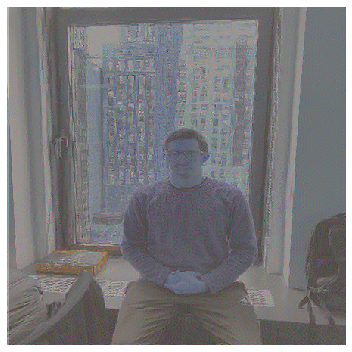

In [15]:
img = get_image_from_model(transfer_model)
show_image(img)